# Module

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import netCDF4
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
import shutil
from scipy.spatial import distance
import metpy
import xskillscore as xs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.feature import NaturalEarthFeature
from glob import *
import sys, os, time, warnings
import pandas as pd
import pytz
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')
from dask.diagnostics import ProgressBar

In [3]:
import metpy

# function  
아래의 함수들 포함.  

fft_1st_phase(a)  
find_nearest(array, value)  
find_nearest_idx(array, value) 
harm_1st_max_idx(array, values)  
diurnal_cycle_fig(data,daily_mean_data,time,data_source)  
grid_transfer(data)  
regrid(change_data,target_data)  
amplitude_fig(data,data_source)amplitude_fig(data,data_source)  
 print(f"latitude : {i}", end='\r') print(f"latitude : {i}", end='\r') # 순서 보여주는거


### harmonic analysis function

In [4]:
def fft_1st_phase(a):
    ff = np.fft.fft(a)
    # Get the complex vector at that frequency to retrieve amplitude and phase shift
    yy = ff[1] 

    # Calculate the amplitude
    T = a.shape[0] # domain of x; which we will divide height to get freq amplitude
    A = np.sqrt(yy.real**2 + yy.imag**2)/T 
    # print('amplitude of:', A) 
    
    # Calculate phase shift
    phi = np.arctan(yy.imag/yy.real)
    # print('phase change:', phi)
    
    return phi, yy.real ,A


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def harm_1st_max_idx(array, values): # 앞에가 시간 뒤에가 강수
    pp=0
    if fft_1st_phase(values)[1]>0:
        if fft_1st_phase(values)[0]<0:
            pp = -fft_1st_phase(values)[0]/np.pi *np.pi
        elif fft_1st_phase(values)[0]>0:
            pp = ( 2. - fft_1st_phase(values)[0]/np.pi ) *np.pi
    elif fft_1st_phase(values)[1]<0:
        pp = ( -fft_1st_phase(values)[0]/np.pi + 1. ) *np.pi    
    
    pp2 = np.nanmax(array,axis=0) * pp / (2.*np.pi)    
    return find_nearest_idx(array, pp2)

### diurnal cycle fig function

In [5]:
def diurnal_cycle_fig(data,daily_mean_data,time,data_source):

    if time == 'utc':
        tt = 'UTC(hour)'
    else : 
        tt = 'LST(hour)'
        
    tick_spacing = 30

    projection = ccrs.PlateCarree()
    crs = ccrs.PlateCarree()
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=projection, frameon=True)


    varMin, varMax, varInt = 0, 24, 1
    levels = np.arange(varMin, varMax+varInt, varInt)
    nlevs  = levels.size
    tick_interval = 2
    cmap = plt.get_cmap('Spectral', nlevs)
    extent=[-180, 180, -60, 60]
    gl = ax.gridlines(crs=crs, draw_labels=True, linewidth=1, color='gray', alpha=1, linestyle='-.')
    gl.xlabel_style = {"size" : 13}
    gl.ylabel_style = {"size" : 13}
    gl.xlocator = mticker.FixedLocator(np.arange(extent[0], extent[1] + tick_spacing, tick_spacing))
    gl.ylocator = mticker.FixedLocator(np.arange(extent[2], extent[3] + tick_spacing, tick_spacing))

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter()) 

    gl.top_labels = None
    gl.right_labels = None

    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), lw=0.8)
    ax.add_feature(cfeature.OCEAN.with_scale("50m"), edgecolor='none', facecolor='lightgray')
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), lw=0.3)
    ax.set_extent([-180, 180, -60, 60], crs=ccrs.PlateCarree())

    lons = data['longitude']  # 경도
    lats = data['latitude']  # 위도
    values = data[time]

    lons, lats = np.meshgrid(data['longitude'], data['latitude'])

    cnplot = ax.contourf(lons, lats, values,cmap=cmap,levels=levels,zorder=0,transform=ccrs.PlateCarree())

    cbar = plt.colorbar(cnplot,ticks=np.arange(varMin, varMax+tick_interval, tick_interval), 
                        orientation='vertical', pad=0.01, shrink=.575) 

    zm = np.ma.masked_less(daily_mean_data, 0.275)
    plt.pcolor(lons, lats,zm, hatch='xxx', alpha=0.)

    cbar.set_label(tt, fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    plt.xlabel('Longitude',fontsize=10,fontweight='bold')
    plt.ylabel('Latitude',fontsize=10,fontweight='bold')    
    ax.set_title(data_source+' [JJA 2022]',fontsize=20,fontweight='bold')
    plt.show()


### grid inverse function

In [6]:
def grid_transfer(data):
    data=data.sortby(data['latitude'], ascending=True) #위도 ㅂ반전
    data['longitude'] = xr.where(data['longitude'] > 180, data['longitude'] - 360, data['longitude']) # 경도 반전
    data = data.sortby(data['longitude']) #바뀐 경도에 대해 값들 맞춰줌 한번만 실행할것
    
    return data

### amplitude_fig

In [7]:
def amplitude_fig(data,data_source):

    tick_spacing = 30
    projection = ccrs.PlateCarree()
    crs = ccrs.PlateCarree()
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes(projection=projection, frameon=True)


    varMin, varMax, varInt = 0, 2, 0.1
    levels = np.arange(varMin, varMax+varInt, varInt)
    nlevs  = levels.size
    tick_interval = 0.2
    cmap = plt.get_cmap('plasma', nlevs)
    extent=[-180, 180, -60, 60]

    gl = ax.gridlines(crs=crs, draw_labels=True, linewidth=1, color='gray', alpha=1, linestyle='-.')
    gl.xlabel_style = {"size" : 13}
    gl.ylabel_style = {"size" : 13}
    gl.xlocator = mticker.FixedLocator(np.arange(extent[0], extent[1] + tick_spacing, tick_spacing))
    gl.ylocator = mticker.FixedLocator(np.arange(extent[2], extent[3] + tick_spacing, tick_spacing))

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter()) 

    gl.top_labels = None
    gl.right_labels = None

    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), lw=0.8)
    ax.add_feature(cfeature.OCEAN.with_scale("50m"), edgecolor='none', facecolor='lightgray')
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), lw=0.3)
    ax.set_extent([-180, 180, -60, 60], crs=ccrs.PlateCarree())

    lons = data['longitude']  # 경도
    lats = data['latitude']  # 위도
    values = data['amlitude']

    lons, lats = np.meshgrid(data['longitude'], data['latitude'])

    cnplot = ax.contourf(lons, lats, values,cmap=cmap,levels=levels,zorder=0,
                         transform=ccrs.PlateCarree(),extend='max')

    cbar = plt.colorbar(cnplot,ticks=np.arange(varMin, varMax+tick_interval, tick_interval), 
                        orientation='vertical', pad=0.01, shrink=.56) 

    # zm = np.ma.masked_less(daily_mean_data, 0.275)
    # plt.pcolor(lons, lats,zm, hatch='xxx', alpha=0.)

    cbar.set_label('Amplitude', fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    plt.xlabel('Longitude',fontsize=10,fontweight='bold')
    plt.ylabel('Latitude',fontsize=10,fontweight='bold')    
    ax.set_title(data_source+' [JJA 2022]',fontsize=20,fontweight='bold')
    plt.show()


### grid same

In [8]:
import xesmf as xe

In [24]:
def regrid(change_data,target_data):
    grid_frame = xe.Regridder(change_data, target_data, "bilinear")
    regrid_data=grid_frame(change_data)
    return regrid_data

# 

In [25]:
file_list=sorted(glob('/data1/user/gychoi/Data/simple_tfs/yearly/*'))

In [26]:
eralist=xr.open_mfdataset(file_list)

In [27]:
eralist

<xarray.Dataset>
Dimensions:    (time: 44, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 1979-12-31 1980-12-31 ... 2022-12-31
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    efam       (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    pream      (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    prepm      (time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

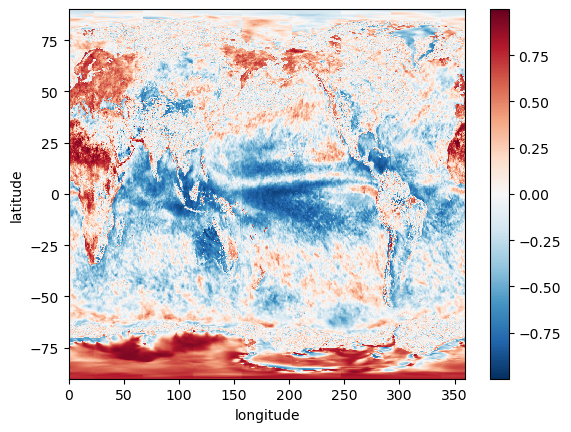

In [41]:
cor.plot()

In [16]:
with ProgressBar():
    
    pre_thr = 1.
    bins = 10

    #이용할 데이터 선택하기 
    #오후강수가 thr보다 크고 오전강수가 thr보다 작은 날짜 사용

    idx = xr.where(eralist['pream']<pre_thr,1,0) # 각 자료의  nan값이 없고 오전의 강수가 thr보다 작은 데이터만 선택함.

    ef  = eralist['efam'].where(idx==1) #그 날짜만 선택해줌///...

    pre  = eralist['prepm'].where(idx==1)
    pev =  xr.where(pre>=pre_thr,1,0) # 오후 강수 확률을 계산해주기 위함임.pre>=pre_thr인곳은 1, 아닌곳은 0으로 해주기


    percentile = np.arange(0,1+0.1,bins/100)
    quantile = []

    for i in range (len(percentile)):

        quantile.append(ef.quantile(percentile[i], dim='time'))
        print(f"quantile : {i}", end='\r')

    q = xr.concat(quantile,'quantile') 
    print('Complete concat')

    # 구간별로 따로 리스트에 넣어줘야 할듯
    r =  [] # 오후 강수 확률
    e =  [] # 오후 강우강도
    efo =  [] # ef의 구간 평균 

    
    for nz in range(bins) :

        ind=xr.where(((ef > q['quantile'][nz]) & (ef <= q['quantile'][nz+1])),1,0)
        efo.append(ef.where(ind==1).mean('time'))
        r.append(pev.where(ind==1).mean('time')) # TFS 만들기 위한 확률 구하기

        pret =  pre.where(ind==1) # # AFS 만들기 위함
        e.append(pret.where(pret >= pre_thr).mean('time').fillna(0)) # 구간에 속하는 평균 강수량 jja 평균이겠지?
         #nan값을 0으로 해줌 비가 안온 날로 해야하는거임.
        print(f"nz : {nz}", '/9', end='\r')

    sumtfs =  0
    sumafs =  0

    for nz in range(1,bins):
        sumtfs =  sumtfs + (r[nz] - r[nz-1]) / (bins*(efo[nz] - efo[nz-1]))

        sumafs =  sumafs + (e[nz] - e[nz-1]) / (bins*(efo[nz] - efo[nz-1]))
        print(f"nz : {nz}", '/9', end='\r')
    efstd=ef.std('time') 

    tfs=sumtfs*efstd

    afs=sumafs*efstd


Complete concat


In [28]:
efam=xr.open_dataarray('/data1/user/gychoi/Data/simple_tfs/concat/ef9322.nc')

In [ ]:
efam.sel(time = 2022)